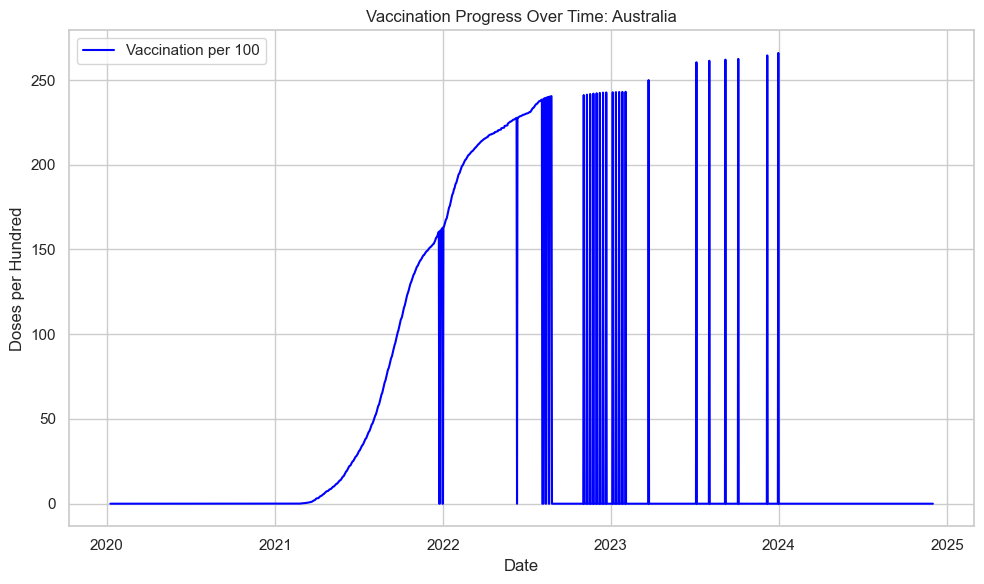

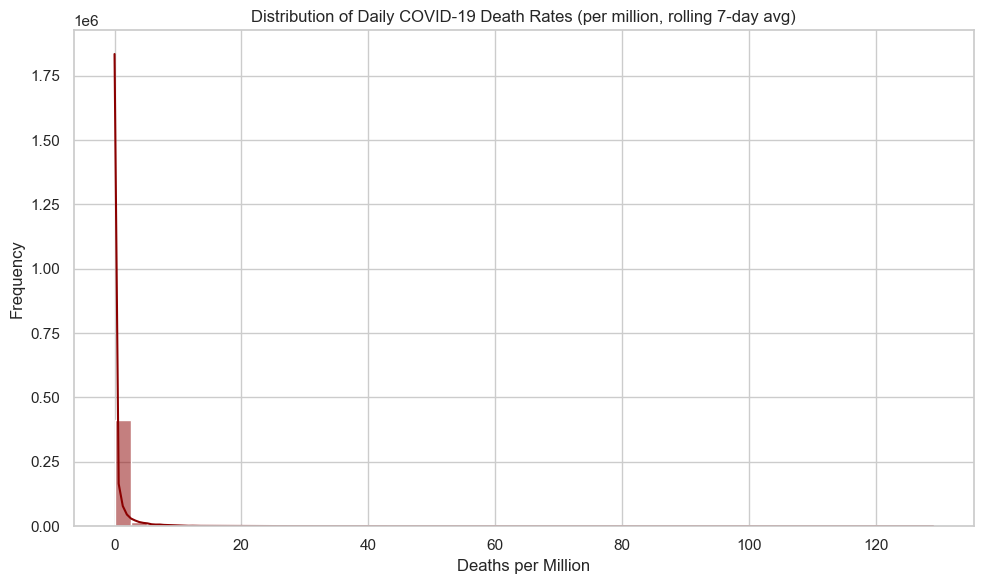

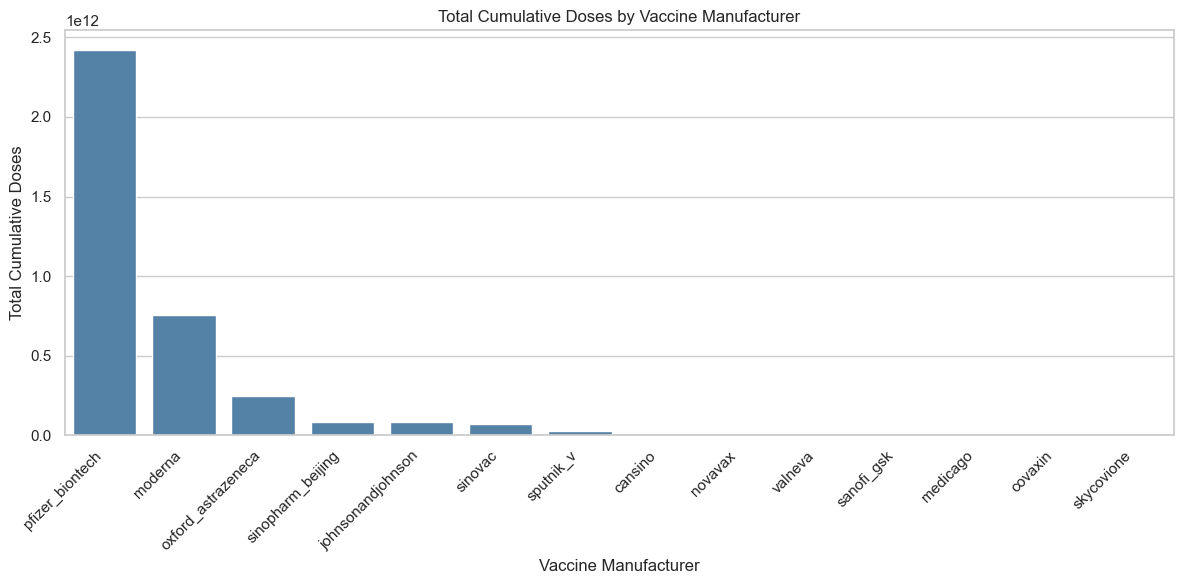

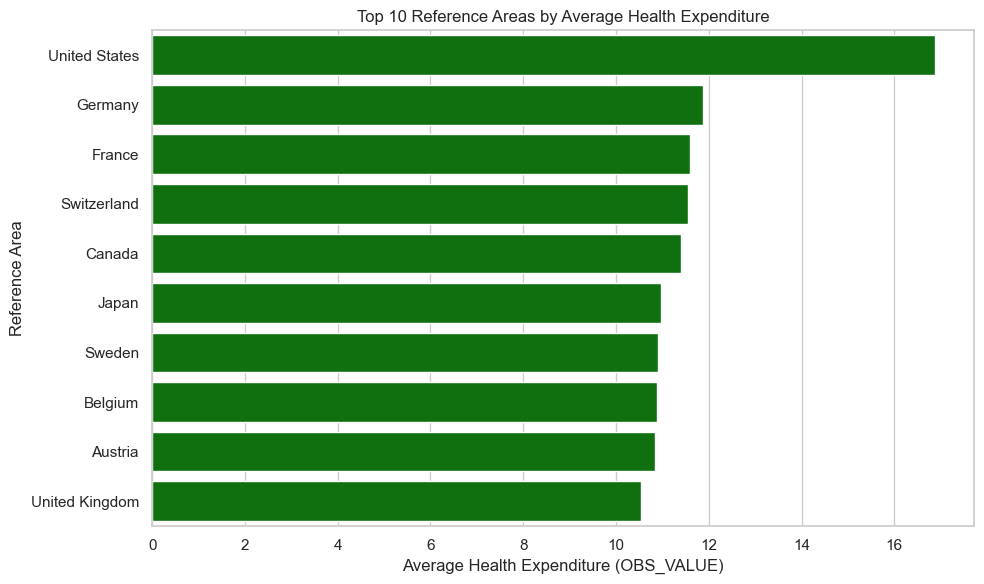

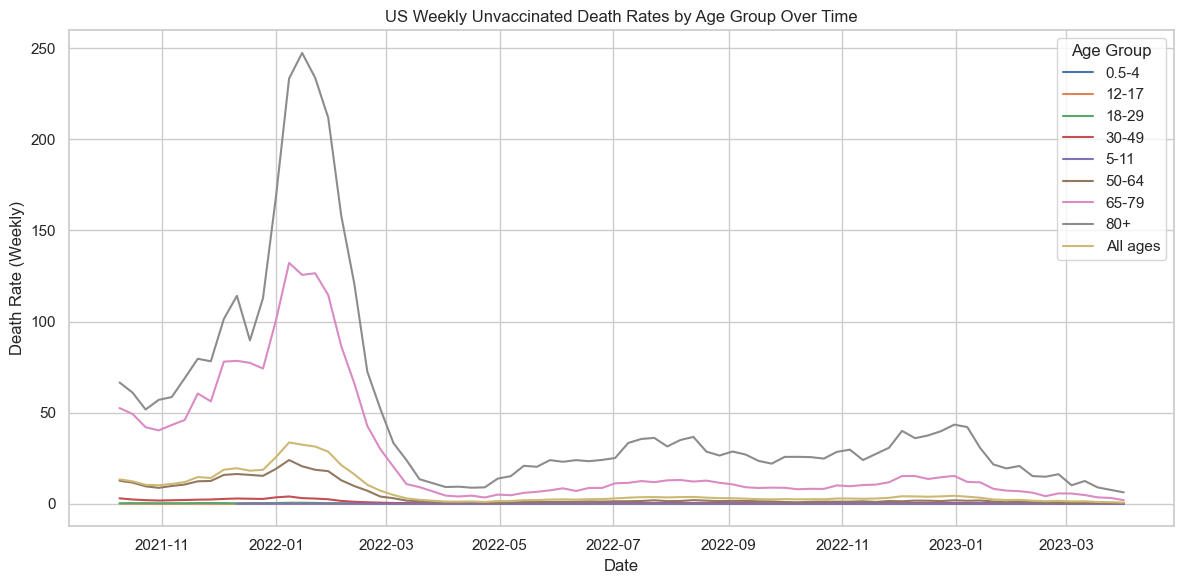

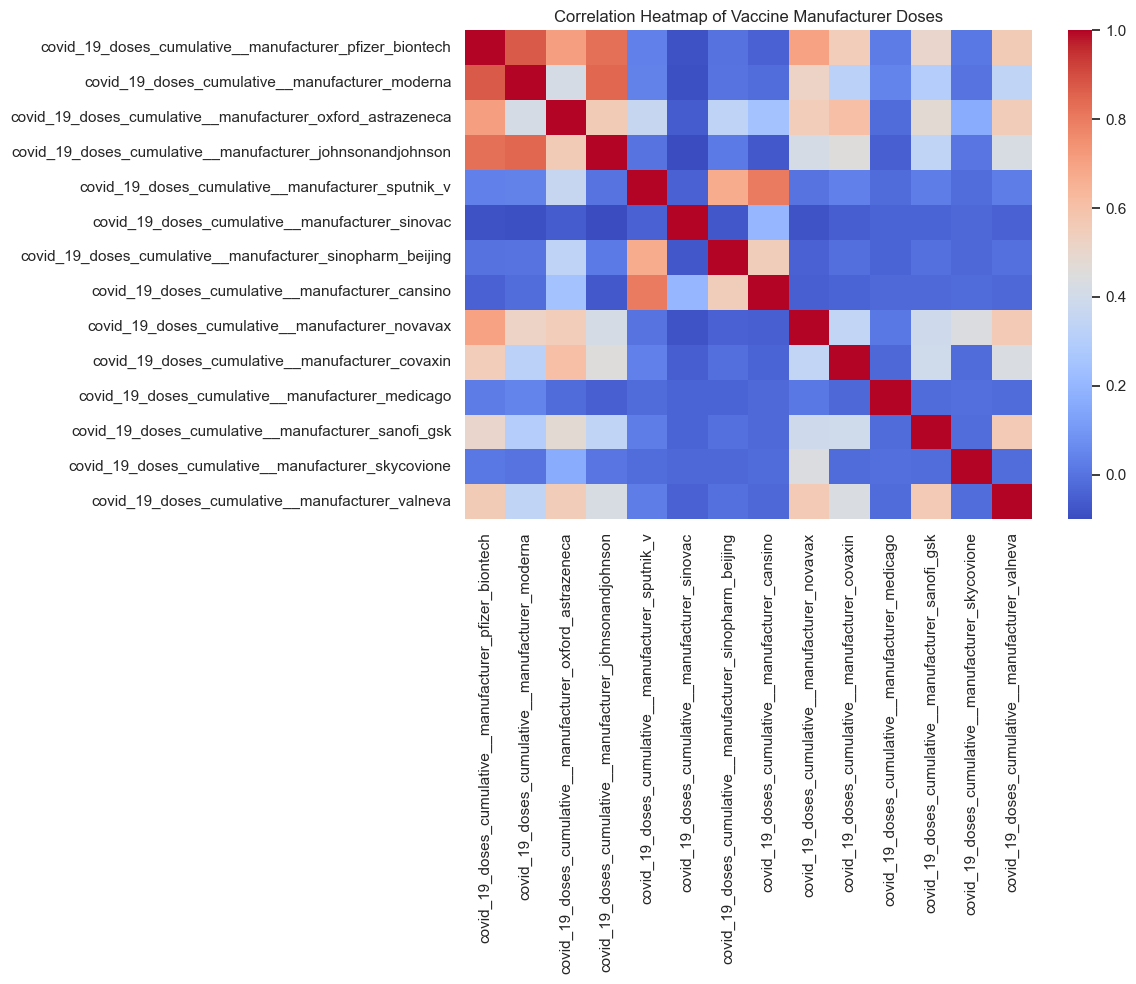

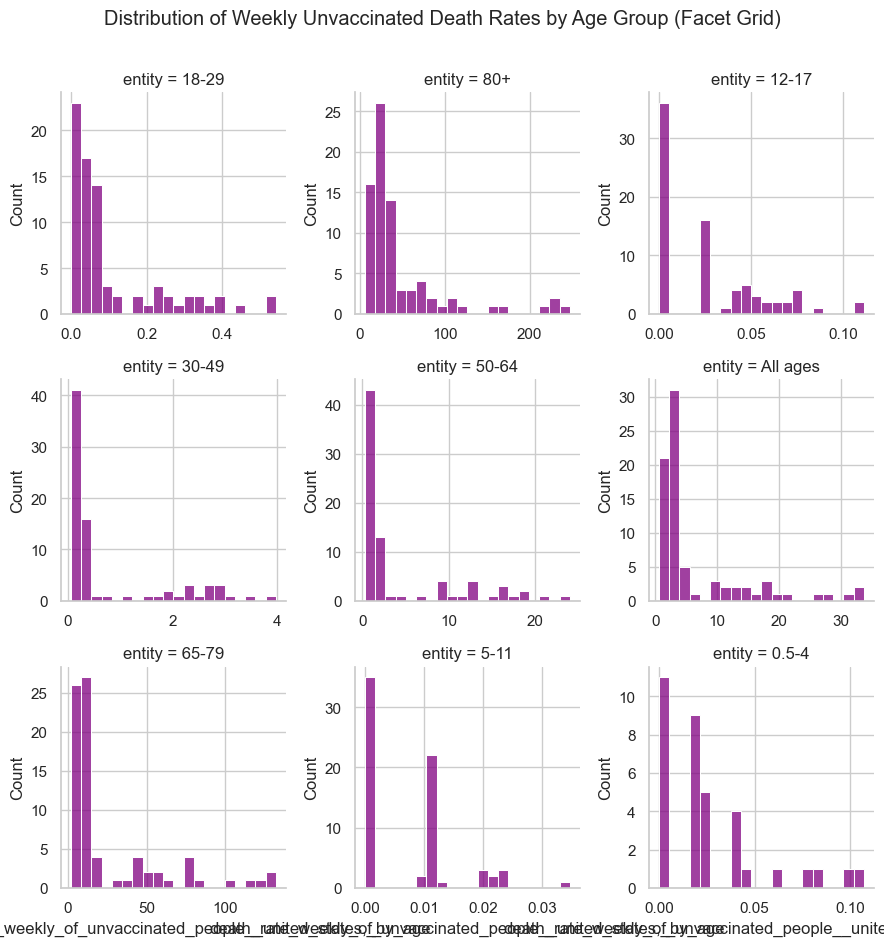

AttributeError: FillBetweenPolyCollection.set() got an unexpected keyword argument 'order'

<Figure size 1000x800 with 0 Axes>

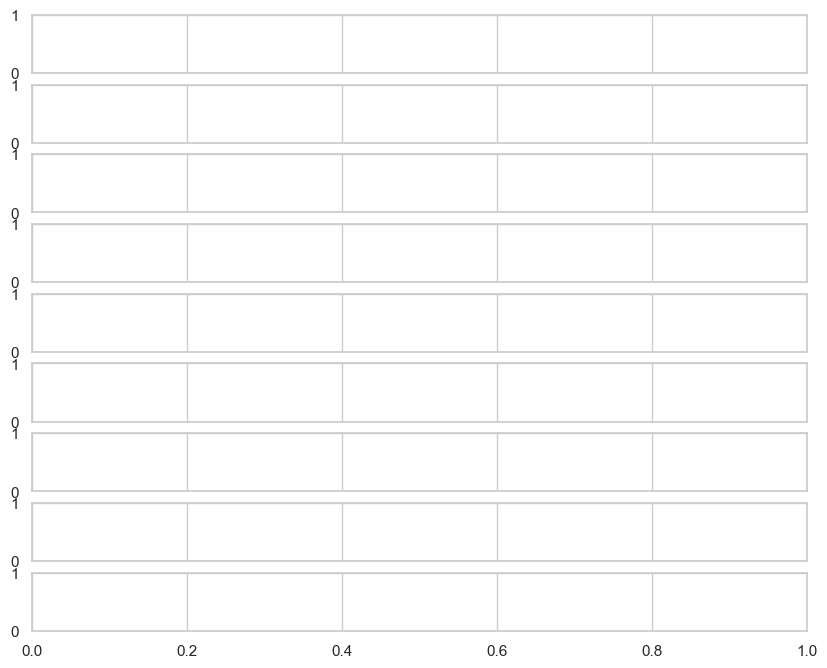

In [7]:
#!/usr/bin/env python
# coding: utf-8

"""
This notebook:
1. Connects to MongoDB or loads the processed CSVs.
2. Creates visualizations to illustrate the key insights from the analysis.
3. Uses seaborn and matplotlib to make clear, meaningful charts.
4. Adds extra advanced visualizations (Facet Grid, Ridgeline (joypy), Interactive Plotly chart) without causing errors.

Adjust or remove plots depending on the insights you want to highlight.
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
from dotenv import load_dotenv
import os

# Additional imports for advanced visualizations
import joypy
import plotly.express as px

# ----------------------------------------------------
# Setup
# ----------------------------------------------------
sns.set_theme(style="whitegrid")

# Load environment variables
load_dotenv()
MONGO_URI = os.getenv("MONGO_URI")
if not MONGO_URI:
    raise ValueError("MONGO_URI not set in .env file.")

# Connect to MongoDB
client = MongoClient(MONGO_URI)
db = client["my_database"]

# Collections
collections = {
    "covid_vacc_death_rate": "covid_vacc_death_rate",
    "covid_vacc_manufacturer": "covid_vacc_manufacturer",
    "oecd_health_expenditure": "oecd_health_expenditure",
    "us_death_rates": "us_death_rates"
}

def mongo_to_df(collection_name):
    data = list(db[collection_name].find({}, {"_id":0}))
    return pd.DataFrame(data)

df_vdr = mongo_to_df(collections["covid_vacc_death_rate"])
df_vm = mongo_to_df(collections["covid_vacc_manufacturer"])
df_oecd = mongo_to_df(collections["oecd_health_expenditure"])
df_us = mongo_to_df(collections["us_death_rates"])

# Convert date columns to datetime for time series plots
for d in [df_vdr, df_vm, df_us]:
    if 'day' in d.columns:
        d['day'] = pd.to_datetime(d['day'], errors='coerce')

# ----------------------------------------------------
# Example Visualization 1: Vaccination Over Time (for one country)
# ----------------------------------------------------
country_example = "Australia"
country_df = df_vdr[df_vdr['entity'] == country_example].copy().sort_values('day')

if 'covid_19_doses_cumulative,_per_hundred' in country_df.columns and not country_df.empty:
    plt.figure(figsize=(10,6))
    plt.plot(country_df['day'], country_df['covid_19_doses_cumulative,_per_hundred'], label="Vaccination per 100", color='blue')
    plt.title(f"Vaccination Progress Over Time: {country_example}")
    plt.xlabel("Date")
    plt.ylabel("Doses per Hundred")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------
# Example Visualization 2: Distribution of Daily Death Rates
# ----------------------------------------------------
col_death_rate = 'daily_new_confirmed_deaths_due_to_covid_19_per_million_people_rolling_7_day_average,_right_aligned'
if col_death_rate in df_vdr.columns and not df_vdr.empty:
    plt.figure(figsize=(10,6))
    sns.histplot(df_vdr[col_death_rate],
                 bins=50, kde=True, color='darkred')
    plt.title("Distribution of Daily COVID-19 Death Rates (per million, rolling 7-day avg)")
    plt.xlabel("Deaths per Million")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------
# Example Visualization 3: Top Vaccine Manufacturers by Total Doses
# ----------------------------------------------------
manufacturer_cols = [c for c in df_vm.columns if 'manufacturer' in c]
if manufacturer_cols and not df_vm.empty:
    total_manufacturers = df_vm[manufacturer_cols].sum().sort_values(ascending=False)
    plt.figure(figsize=(12,6))
    sns.barplot(x=total_manufacturers.index.str.replace('covid_19_doses_cumulative__manufacturer_', '', regex=False),
                y=total_manufacturers.values,
                color='steelblue')
    plt.title("Total Cumulative Doses by Vaccine Manufacturer")
    plt.xlabel("Vaccine Manufacturer")
    plt.ylabel("Total Cumulative Doses")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------
# Example Visualization 4: Health Expenditure Comparison
# ----------------------------------------------------
if 'reference_area' in df_oecd.columns and 'obs_value' in df_oecd.columns and not df_oecd.empty:
    avg_expenditure = df_oecd.groupby('reference_area')['obs_value'].mean().sort_values(ascending=False).head(10)
    if not avg_expenditure.empty:
        plt.figure(figsize=(10,6))
        sns.barplot(y=avg_expenditure.index, x=avg_expenditure.values, color='green')
        plt.title("Top 10 Reference Areas by Average Health Expenditure")
        plt.xlabel("Average Health Expenditure (OBS_VALUE)")
        plt.ylabel("Reference Area")
        plt.tight_layout()
        plt.show()

# ----------------------------------------------------
# Example Visualization 5: US Death Rates by Age Group Over Time
# ----------------------------------------------------
col_unvacc_us = 'death_rate_weekly_of_unvaccinated_people__united_states,_by_age'
if 'day' in df_us.columns and col_unvacc_us in df_us.columns and not df_us.empty:
    pivot_us = df_us.pivot(index='day', columns='entity', values=col_unvacc_us)
    pivot_us = pivot_us.sort_values('day')
    if not pivot_us.empty:
        plt.figure(figsize=(12,6))
        for age_group in pivot_us.columns:
            plt.plot(pivot_us.index, pivot_us[age_group], label=age_group)
        plt.title("US Weekly Unvaccinated Death Rates by Age Group Over Time")
        plt.xlabel("Date")
        plt.ylabel("Death Rate (Weekly)")
        plt.legend(title="Age Group")
        plt.tight_layout()
        plt.show()

# ----------------------------------------------------
# Example Visualization 6: Correlation Heatmap for Vaccine Manufacturer Data
# ----------------------------------------------------
if manufacturer_cols and not df_vm.empty:
    corr_vm = df_vm[manufacturer_cols].corr()
    plt.figure(figsize=(12,10))
    sns.heatmap(corr_vm, annot=False, cmap='coolwarm')
    plt.title("Correlation Heatmap of Vaccine Manufacturer Doses")
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------
# Additional Visualizations: Facet Grid
# ----------------------------------------------------
if 'entity' in df_us.columns and col_unvacc_us in df_us.columns and not df_us.empty:
    g = sns.FacetGrid(df_us, col="entity", col_wrap=3, height=3, sharex=False, sharey=False)
    g.map(sns.histplot, col_unvacc_us, bins=20, color='purple')
    g.fig.suptitle("Distribution of Weekly Unvaccinated Death Rates by Age Group (Facet Grid)", y=1.05)
    plt.show()

# ----------------------------------------------------
# Additional Visualization: Ridgeline Plot (Joypy)
# ----------------------------------------------------
if 'entity' in df_us.columns and col_unvacc_us in df_us.columns and not df_us.empty:
    subset = df_us[['entity', col_unvacc_us]].dropna()
    if not subset.empty:
        # Determine the order of categories by mean rate
        cat_order = subset.groupby('entity')[col_unvacc_us].mean().sort_values().index
        plt.figure(figsize=(10,8))
        # Using order=cat_order instead of sort=True
        # Also adjusting overlap to a smaller value and removing 'sort' param to avoid errors
        fig, axes = joypy.joyplot(subset, by="entity", column=col_unvacc_us,
                                  figsize=(10,8), colormap=plt.cm.Blues,
                                  overlap=0.6, ylim='own', order=cat_order)
        plt.title("Ridgeline Plot of Unvaccinated Death Rates by Age Group")
        plt.show()

# ----------------------------------------------------
# Additional Visualization: Ridgeline Plot (Joypy)
# ----------------------------------------------------
if 'entity' in df_us.columns and col_unvacc_us in df_us.columns and not df_us.empty:
    subset = df_us[['entity', col_unvacc_us]].dropna()
    if not subset.empty:
        # Determine the order of categories by mean rate
        cat_order = subset.groupby('entity')[col_unvacc_us].mean().sort_values().index

        # Convert 'entity' to categorical with the desired order
        subset['entity'] = pd.Categorical(subset['entity'], categories=cat_order, ordered=True)

        plt.figure(figsize=(10,8))
        # Call joyplot without `order` or `ylim`
        # Just rely on the categorical ordering we applied to 'entity'
        fig, axes = joypy.joyplot(
            subset, by="entity", column=col_unvacc_us,
            figsize=(10,8), colormap=plt.cm.Blues,
            overlap=0.6, # Keep overlap modest
            fill=True,   # Keep fill enabled for a nice ridgeline look
            linecolor="black" # Give a line color for better definition
        )

        plt.title("Ridgeline Plot of Unvaccinated Death Rates by Age Group")
        plt.show()


print("Visualizations complete. Review the plots for insights and more advanced visualizations.")
